In [1]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

from IPython.display import HTML

from hcipy import *

In [2]:
def make_magaox_bump_mask(normalized=False, with_spiders=True):
    '''Make the Magellan bump mask.

    Parameters
    ----------
    normalized : boolean
        If this is True, the outer diameter will be scaled to 1. Otherwise, the
        diameter of the pupil will be 6.5 meters.
    with_spiders: boolean
        If this is False, the spiders will be left out.

    Returns
    -------
    Field generator
        The Magellan aperture.
    '''

    # TODO: Magnify bump mask vals. and preserve default vals

    magnification_factor = 6.5/9e-3 # Mag factor to scale 9 mm bump mask up to 6.5 m pupil diameter
    mask_inner = 2.79e-3 * magnification_factor # meter
    mask_outer = 8.604e-3 * magnification_factor # meter

    bump_mask_diameter = 0.5742e-3 * magnification_factor

    bump_mask_pos = [2.853e-3 * magnification_factor, -0.6705e-3 * magnification_factor] 

    radius = np.hypot(bump_mask_pos[0], bump_mask_pos[1])
    theta = np.arctan2(bump_mask_pos[1], bump_mask_pos[0]) - np.rad2deg(38.7747) + np.pi/2 # Adjusted bump angle to better center it on spider
    bump_mask_pos = [radius * np.cos(theta), radius * np.sin(theta)]



    pupil_diameter = 6.5 # meter
    spider_width1 = 0.1917e-3 * magnification_factor # meter 
    spider_width2 = 0.1917e-3  * magnification_factor # meter
    central_obscuration_ratio = mask_inner / mask_outer 
    spider_offset = [0, 0.34]  # meter

    if normalized:
        spider_width1 /= pupil_diameter
        spider_width2 /= pupil_diameter
        spider_offset = [x / pupil_diameter for x in spider_offset]
        pupil_diameter = 1.0

    spider_offset = np.array(spider_offset)

    mirror_edge1 = (pupil_diameter / (2 * np.sqrt(2)), pupil_diameter / (2 * np.sqrt(2)))
    mirror_edge2 = (-pupil_diameter / (2 * np.sqrt(2)), pupil_diameter / (2 * np.sqrt(2)))
    mirror_edge3 = (pupil_diameter / (2 * np.sqrt(2)), -pupil_diameter / (2 * np.sqrt(2)))
    mirror_edge4 = (-pupil_diameter / (2 * np.sqrt(2)), -pupil_diameter / (2 * np.sqrt(2)))

    obstructed_aperture = make_obstructed_circular_aperture(pupil_diameter, central_obscuration_ratio)
    bump_mask = make_circular_aperture(bump_mask_diameter, center=bump_mask_pos) # Generate bump cover for Magellan pupil
    
    if not with_spiders:
        return obstructed_aperture

    spider1 = make_spider(spider_offset, mirror_edge1, spider_width1)
    spider2 = make_spider(spider_offset, mirror_edge2, spider_width1)
    spider3 = make_spider(-spider_offset, mirror_edge3, spider_width2)
    spider4 = make_spider(-spider_offset, mirror_edge4, spider_width2)

    def func(grid):
        return obstructed_aperture(grid) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid) * (1 - bump_mask(grid))
    return func

In [3]:
# Set units

magnification_factor = (9*1e-3)/6.5
pupil_diameter = 6.5
# effective_focal_length = 71.5 
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution

# Set up pupil/focal grids
mpl.rcParams['figure.dpi'] = 100


pupil_grid = make_pupil_grid(256, diameter=pupil_diameter)
focal_grid = make_focal_grid(q=4, num_airy=16, pupil_diameter=pupil_diameter, focal_length=effective_focal_length, reference_wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)



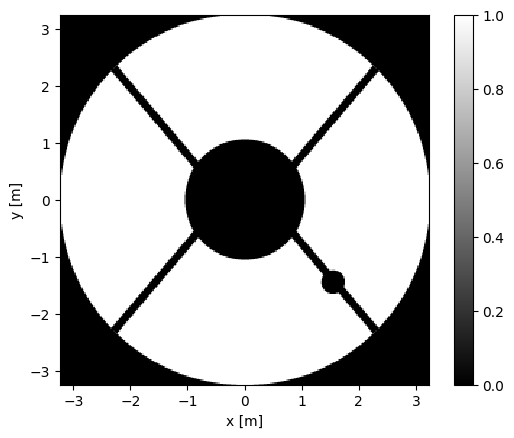

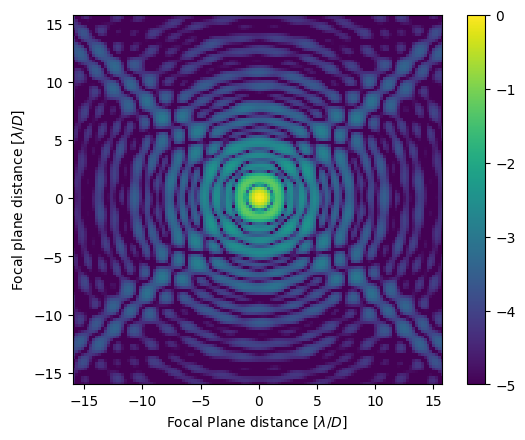

In [4]:
# Plot the bump mask scaled up to MagAO-X pupil diameter



telescope_pupil = evaluate_supersampled(make_rotated_aperture(make_magaox_bump_mask(), np.pi/2), pupil_grid, 4)


# telescope_pupil_generator = make_magellan_aperture()
# telescope_pupil = telescope_pupil_generator(pupil_grid)

# Plot telescope pupil
imshow_field(telescope_pupil, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

wavefront = Wavefront(telescope_pupil, wavelength)


focal_image = prop.forward(wavefront)

norm = focal_image.intensity.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()

# telescope_pupil = evaluate_supersampled(make_magellan_aperture(), pupil_grid, 4)


# # telescope_pupil_generator = make_magellan_aperture()
# # telescope_pupil = telescope_pupil_generator(pupil_grid)

# # Plot telescope pupil
# imshow_field(telescope_pupil, cmap='gray')
# plt.colorbar()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')
# plt.show()

# wavefront = Wavefront(telescope_pupil, wavelength)


# focal_image = prop.forward(wavefront)

# # Plot PSF
# imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5, grid_units=1e-6)
# plt.xlabel('Focal Plane distance [um]')
# plt.ylabel('Focal plane distance [um]')
# plt.colorbar()
# plt.show()

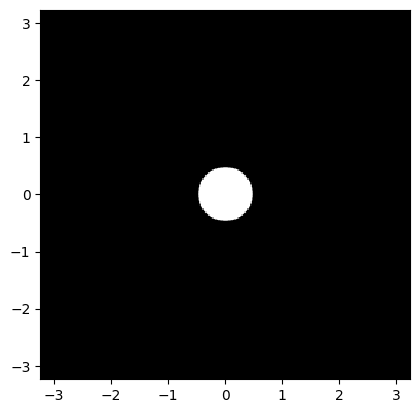

In [5]:
# Generate slightly undersized Lyot Stop
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95), pupil_grid, 4)
imshow_field(lyot_mask, cmap='gray')
plt.show()

In [6]:
# Generate order 2 perfect CG
order = 2
coro = PerfectCoronagraph(telescope_pupil, order)
lyot_stop = Apodizer(lyot_mask)

In [7]:
# # Propagate light through Perfect CG from pupil plane to Lyot plane
# wf = Wavefront(telescope_pupil)
# lyot_plane = coro(wf)

# imshow_field(lyot_plane.intensity, cmap='inferno')
# plt.colorbar()
# plt.show()

# print(type(coro))

In [8]:
#  Construct 1k DM
num_actuators_across_pupil = 34
actuator_spacing = pupil_diameter / num_actuators_across_pupil
influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across_pupil, actuator_spacing, x_tilt=np.rad2deg(45))
deformable_mirror = DeformableMirror(influence_functions)
num_modes = deformable_mirror.num_actuators

In [9]:
# Create sinusoidal aberration


# help(dm_control_region.influence_functions())

# sa = SurfaceAberration(pupil_grid, 0.2 * wavelength, 6.5)

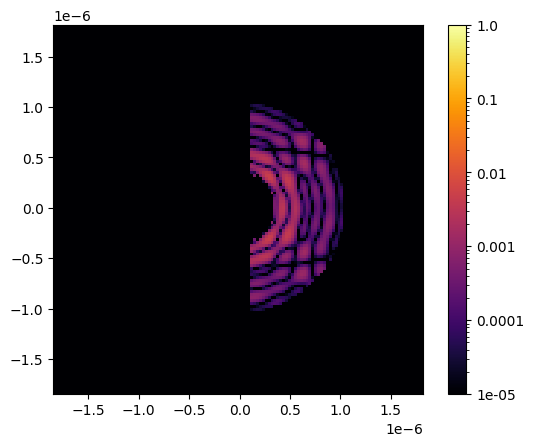

In [10]:
# Define control region
Dtel = 6.5
fourier_grid = make_pupil_grid(32, 32)        # Define grid

fourier_mask = (fourier_grid.as_('polar').r < 9) * (fourier_grid.as_('polar').r > 3)
fourier_mask *= fourier_grid.x > 1

focal_mask = (focal_grid.as_('polar').r < 9*sr) * (focal_grid.as_('polar').r > 3*sr)    # We prev. defined as 1 lambda/D
focal_mask *= focal_grid.x > 1*sr

dark_hole_pixels = focal_image.power*focal_mask # Apply DH mask to image

imshow_psf(dark_hole_pixels/focal_image.power.max() + 1e-16, vmax=1, vmin=1e-5)
plt.show()

# imshow_field(fourier_mask, fourier_grid)        # Define dark hole region
# plt.show()

# selected_modes = fourier_grid.subset(fourier_mask>0)

fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

# Select Fourier modes that fall within DH
selected_modes = fourier_grid.subset(fourier_mask>0)     


# fourier_basis = make_fourier_basis(selected_modes, fourier_grid.scaled(2 * np.pi / Dtel))   # Generate fourier basis from modes within DH region (Double check this, not sure if it makes sense)

# imsho


# fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   

fourier_basis_selected = make_fourier_basis(pupil_grid, selected_modes.scaled(2 * np.pi / Dtel))   # Basis w/ seelected Fourier modes from control region


fourier_dm = DeformableMirror(fourier_basis)
fourier_dm_selected = DeformableMirror(fourier_basis_selected)  # Create DM w/ only the selected modesw from control region


# m = dm.influence_functions[5]

# # print(type(m))
# imshow_field(m)




# ######################################

# # selected_modes = fourier_grid.subset(fourier_mask>0)
# # fourier_basis = make_fourier_basis(pupil_grid, fourier_grid.scaled(2 * np.pi / Dtel))   
# # ripple_mirror = DeformableMirror(fourier_basis)

# # m = ripple_mirror.influence_functions[4]

# # # print(type(m))
# # imshow_field(m)

# # fourier_grid = hcipy.make_pupil_grid(dims=max_HI, diameter=max_HI)  
# # fourier_basis = hcipy.mode_basis.make_fourier_basis(luvoir.pupil_grid, fourier_grid, sort_by_energy=True)
# # ripple_mirror = hcipy.optics.DeformableMirror(fourier_basis)
# # m = ripple_mirror.influence_functions[]
# # hcipy.imshow_field(m)


In [11]:
focal_mask.shape

(16384,)

In [12]:
# Create surface aberration consisting of just a single mode
# sa = SurfaceAberration(pupil_grid, 0.2 * wavelength, 6.5, remove_modes=fourier_basis[1:])   


# type(selected_modes)

# selected_modes

# fourier_dm.num_actuators


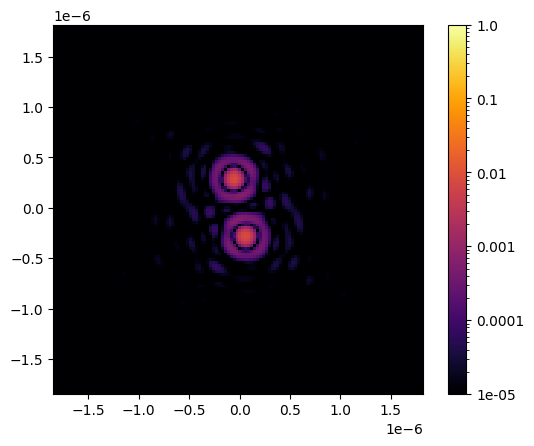

In [13]:
# Determine where actuator falls wrt pupil

fourier_dm.flatten()

probe_amp = 0.01 * wavelength


wf = Wavefront(telescope_pupil, wavelength) # Reference WF
wf.total_power = 1

norm = prop(wf).power.max() # Normalize w/ unaberrated WF


# Apply sin wave to DM
fourier_dm.actuators[20] += probe_amp        


 # Propagate WF through system
dm_wf = fourier_dm.forward(wf) # WF after DM
lyot_wf = coro(dm_wf) # WF in the Lyot Plane
psf = prop(lyot_wf).power
# probed_psfs.append(psf)
# deformable_mirror.actuators[33] = 1.0
# imshow_field(telescope_pupil * (1 + deformable_mirror.surface))
# plt.show()


imshow_psf(psf / norm, vmax=1, vmin=1e-5)
# imshow_psf(prop(dm_wf).power / norm, vmax=1, vmin=1e-5)

plt.show()


# # Define wf
# wf = Wavefront(telescope_pupil, wavelength)
# wf.total_power = 1 


# Propagate aberration through system
# psf = prop(wf).power # prop = lense
# aberrated_psf = prop(sa(wf)).power # prop = lense
# # aberrated_psf = prop(wf).power # prop = lense

# norm = psf.max()

# # corim = prop(coro(wf)).power # prop = lense
# aberrated_corim = prop(coro(sa(wf))).power # prop = lense

# imshow_psf(aberrated_corim / norm, vmax=1, vmin=1e-5) # Plot in log scale
# plt.show()

# aberrated_corim = prop(coro(wf)).power # prop = lense


# plt.subplot(2,2,1)
# imshow_psf(psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
# plt.subplot(2,2,2)
# imshow_psf(aberrated_psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
# plt.subplot(2,2,3)
# imshow_psf(corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
# plt.subplot(2,2,4)
# imshow_psf(aberrated_corim / norm, vmax=1, vmin=1e-5) # Plot in log scale
# plt.show()

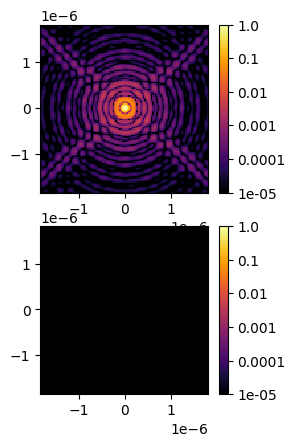

In [14]:
psf = prop(wf).power # prop = lense
# aberrated_psf = prop(sa(wf)).power # prop = lense
norm = psf.max()

corim = prop(coro(wf)).power # prop = lense
# aberrated_corim = prop(coro(sa(wf))).power # prop = lense

plt.subplot(2,2,1)
imshow_psf(psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
# plt.subplot(2,2,2)
# imshow_psf(aberrated_psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,3)
imshow_psf(corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
# plt.subplot(2,2,4)
# imshow_psf(aberrated_corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.show()

In [15]:
# help(help(dm_control_region.influence_functions))
psf.shape

(16384,)

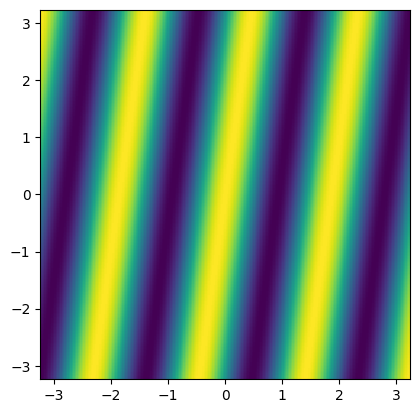

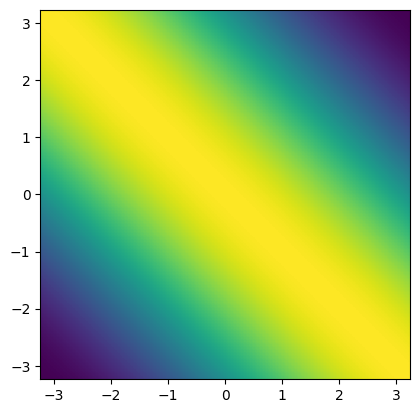

In [16]:
# Determine where actuator falls wrt pupil

# deformable_mirror.flatten()

# deformable_mirror.actuators[4] = 1.0
# imshow_field(telescope_pupil * (1 + deformable_mirror.surface))
# plt.show()


fourier_dm_selected.flatten()

fourier_dm_selected.actuators[0] = 1.0
imshow_field(fourier_dm_selected.surface)
plt.show()


fourier_dm.flatten()

fourier_dm.actuators[0] = 1.0
imshow_field(fourier_dm.surface)
plt.show()

In [18]:

# # # Jacobian (iEFC)

# ########### GITHUB VERSION ##############################

# response_matrix = [] # Initialize empty vector of slopes

# probe_amp = 0.01 * wavelength # Set a probe amplitude
# calibration_amp = 0.01 * wavelength
# # probe_amp2 = 0.01 * wavelength # Set a probe amplitude


# wf = Wavefront(telescope_pupil, wavelength) # Reference WF
# wf.total_power = 1

# norm = prop(wf).power.max() # Normalize w/ unaberrated WF
# # print(norm)
# num_modes = fourier_dm.num_actuators # TODO: Need to constrain number of modes to just the control region? 

# # diff_im_arr = np.zeros((num_modes, num_modes, num_modes))


# #Change num_modes for debugging 
# # num_modes = 20

# amps = np.ones(num_modes) * probe_amp
# # amps2 = np.ones(num_modes) * probe_amp2

# deformable_mirror.flatten()
# fourier_dm.flatten()


# for ind in range(num_modes):
#     if ind % 10 == 0:
#         print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
    
#     calibration_images = []
#     for cal_amp in [-calibration_amp, calibration_amp]:

#         # Add the mode that we are calibrating
#         fourier_dm.actuators[ind] += cal_amp #  (Fourier DM) Ensure that we are only calibrating modes that fall on the pupil

#         difference_images = []
#         for probe_pattern in [400, 401]:
#             # Apply +/- probe 1
#             probed_psfs = []
#             for amp in [-probe_amp, probe_amp]:
#                 deformable_mirror.actuators[probe_pattern] += amp # Apply +/- probe 1 # TODO: Figure out what actuators cover the telescope pupil

#                 # Propagate WF through system
#                 dm_wf = fourier_dm( deformable_mirror.forward(wf) ) # WF after DM
#                 lyot_wf = coro(dm_wf) # WF in the Lyot Plane
#                 psf = prop(lyot_wf).power

#                 probed_psfs.append(psf)
#                 # print(probed_psfs)
#                 deformable_mirror.actuators[probe_pattern] -= amp
#                 # plt.figure()
#                 # imshow_psf(psf / norm, vmin=1e-8, vmax=1e-2)
#             # Compute difference image 1
#             diff_image = probed_psfs[1] - probed_psfs[0]
#             difference_images.append(diff_image)
#             # print()
#         pwp_measurement = np.concatenate((difference_images[0], difference_images[1]))
#         calibration_images.append(pwp_measurement)

#         # Remove the mode that we are calibrating
#         fourier_dm.actuators[ind] -= cal_amp


#     slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

#     response_matrix.append(slope) # Append slope vector to response matrix

#     # diff_im_arr[ind][ind] = difference_images[0]
#     # diff_im_arr[ind][:][ind] = difference_images[1]

#     plt.subplot(1,2,1)
#     imshow_field(difference_images[0])

#     plt.subplot(1,2,2)
#     imshow_field(difference_images[1])
#     plt.show()
#     plt.close()

#     #################################### JACOBIAN PSEUDOCODE IEFC ##################################################
# response_matrix = np.array(response_matrix)
# # Initialize empty vector of slopes (response matrix)
# # For each mode
# #   For amplitude in [-amp, amp]
#     #   Apply mode on DM w/ a given amplitude

#     #   Apply + probe 1
#     #   Propagate WF through system
#     #   Take intensity image (PSF)
#     #   Apply - probe 1
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Compute difference image 1

#     #   Apply + probe 2
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Apply - probe 2
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Compute difference image 2

#     #   Pair-wise probing sensing signal = [diff 1, diff_2]
#     #   Concatenate intensity differences
#     #   Construct slope vector -- amplitude * [(diff 1 - diff 2)/(2*amp)]
# #   Append slope vector to response matrix



In [90]:
# Generate a sequence of pairwise probe, difference images
def make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=EmptyOpticalElement()):
    
    # Generate a 'perform_pwp' function that can be evaluated for a given WF
    def func(wavefront):
        dm.flatten()

        difference_images = []
        for probe_pattern in [probe_1, probe_2]:
            # Apply +/- probe 1
            probed_psfs = []
            for amp in [-probe_amp, probe_amp]:

                dm.actuators[probe_pattern] += amp # Apply +/- probe 1 
                # Propagate WF through system
                dm_wf = dm.forward(wavefront) # WF after DM
                psf = optical_system(dm_wf).power
                probed_psfs.append(psf)
                dm.actuators[probe_pattern] -= amp

            # Compute difference image 1
            diff_image = probed_psfs[1] - probed_psfs[0]
            difference_images.append(diff_image)

        #pwp_measurement = np.concatenate((difference_images[0], difference_images[1]))
        #return pwp_measurement
        return difference_images

    return func

# Create function which will obtain measurements from PWP images
def extract_measurement_from_difference_images(difference_images, dark_hole_mask=dark_hole_pixels, number_of_probes=2):
    difference_dark_hole_pixels = [difference_images[i][dark_hole_mask] for i in range(number_of_probes)]   # Make list of diff DH images
    pwp_measurement = np.concatenate(difference_dark_hole_pixels)   # Combine into a list
    return pwp_measurement

In [133]:
optical_system = OpticalSystem([coro, prop,])
pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=optical_system)

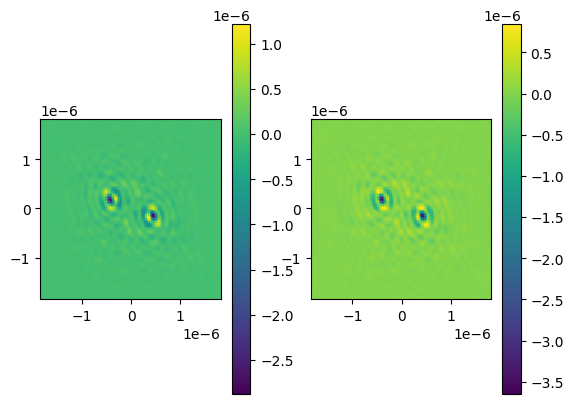

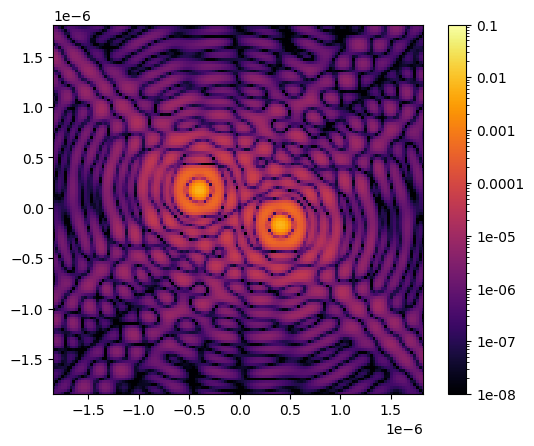

In [138]:
fourier_dm_selected.flatten()
fourier_dm_selected.actuators[10] = 0.01 * wavelength

response = pwp_sensor(fourier_dm_selected(wf))
plt.subplot(1,2,1)
imshow_field(response[0], focal_grid)
plt.colorbar()
plt.subplot(1,2,2)
imshow_field(response[1], focal_grid)
plt.colorbar()
plt.show()

#wfout = optical_system()
wfout = optical_system(fourier_dm_selected(wf))
plt.figure()
imshow_psf(wfout.power/norm)
plt.show()

fourier_dm_selected.flatten()

In [139]:

# # Jacobian (iEFC)

######## EXPERIMENTAl VERSION ##########################



response_matrix_selected = [] # Initialize empty vector of slopes

probe_amp = 0.01 * wavelength # Set a probe amplitude
calibration_amp = 0.01 * wavelength
# probe_amp2 = 0.01 * wavelength # Set a probe amplitude


wf = Wavefront(telescope_pupil, wavelength) # Reference WF
wf.total_power = 1

norm = prop(wf).power.max() # Normalize w/ unaberrated WF
# print(norm)
# num_modes = fourier_dm.num_actuators 

num_modes = fourier_dm_selected.num_actuators # Excite only the modes that fall within control region


# TODO: Debug the image array b/c I'm doing something wrong
# diff_im_arr = np.zeros((num_modes, psf.shape[0], psf.shape[1]))
# diff_im_arr = focal_grid.zeros((num_modes,))    # Initialize empty array for storing diff images
# diff_im_arr.shape = (num_modes, psf.size)

#Change num_modes for debugging 
# num_modes = 20

amps = np.ones(num_modes) * probe_amp
# amps2 = np.ones(num_modes) * probe_amp2

deformable_mirror.flatten()
fourier_dm_selected.flatten()


for ind in range(num_modes):
    if ind % 10 == 0:
        print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
    
    calibration_images = []
    for cal_amp in [-calibration_amp, calibration_amp]:

        # Add the mode that we are calibrating
        fourier_dm_selected.actuators[ind] += cal_amp #  (Fourier DM) Ensure that we are only calibrating modes that fall on the pupil

        diff_images = pwp_sensor(fourier_dm_selected(wf))  # Perform PWP

        pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels>0) # Extract diff image measurements for DH region
        
        calibration_images.append(pwp_measurement)

        #plt.figure()
        #imshow_field(diff_images[0])

        # Remove the mode that we are calibrating
        fourier_dm_selected.actuators[ind] -= cal_amp

    slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

    response_matrix_selected.append(slope) # Append slope vector to response matrix

    # diff_im_arr[ind] = difference_images[0]
    # if ind % 2 != 0:
    #     diff_im_arr[ind] = difference_images[1]
    # # plt.subplot(1,2,1)
    # imshow_field(difference_images[0])

    # plt.subplot(1,2,2)
    # imshow_field(difference_images[1])
    # plt.show()
    # plt.close()

response_matrix_selected = np.array(response_matrix_selected)

    #################################### JACOBIAN PSEUDOCODE IEFC ##################################################
# Initialize empty vector of slopes (response matrix)
# For each mode
#   For amplitude in [-amp, amp]
    #   Apply mode on DM w/ a given amplitude

    #   Apply + probe 1
    #   Propagate WF through system
    #   Take intensity image (PSF)
    #   Apply - probe 1
    #   Propagate WF through system
    #   Take intensity image
    #   Compute difference image 1

    #   Apply + probe 2
    #   Propagate WF through system
    #   Take intensity image
    #   Apply - probe 2
    #   Propagate WF through system
    #   Take intensity image
    #   Compute difference image 2

    #   Pair-wise probing sensing signal = [diff 1, diff_2]
    #   Concatenate intensity differences
    #   Construct slope vector -- amplitude * [(diff 1 - diff 2)/(2*amp)]
#   Append slope vector to response matrix



Measure response to mode 1 / 200
Measure response to mode 11 / 200
Measure response to mode 21 / 200
Measure response to mode 31 / 200
Measure response to mode 41 / 200
Measure response to mode 51 / 200
Measure response to mode 61 / 200
Measure response to mode 71 / 200
Measure response to mode 81 / 200
Measure response to mode 91 / 200
Measure response to mode 101 / 200
Measure response to mode 111 / 200
Measure response to mode 121 / 200
Measure response to mode 131 / 200
Measure response to mode 141 / 200
Measure response to mode 151 / 200
Measure response to mode 161 / 200
Measure response to mode 171 / 200
Measure response to mode 181 / 200
Measure response to mode 191 / 200


In [123]:
# # TODO: Get animation to work!!! Ask Jaren.

# # fig = plt.figure()
# # im = imshow_field(focal_grid.x, focal_grid)
# # title = plt.title('',fontsize = 'xx-large')
# plt.close()

# def animate(i):
#     # print(i)
#     diff_images = diff_im_arr[i]
#     # wavefront_out = vAPP_pol.forward(wavefront)

#     # vAPP_PSF = Field((prop(wavefront_out).I),focal_grid)
#     # vAPP_PSF /= vAPP_PSF.max()

#     # x, y = focal_grid.coords.separated_coords
#     im = imshow_field(diff_images)
    
#     if i % 2 == 0:
#         title.set_text('Mode = {0}'.format(i))
#     # else:
#     #     title.set_text('Mode = {0}'.format(i))
#     return im, title

# ani = animation.FuncAnimation(fig, animate, range(len(diff_im_arr)), blit=True)
# HTML(ani.to_html5_video())


In [188]:
# Compute reconstruction matrix
rcond = 1e-1
reconstruction_matrix_selected = inverse_tikhonov(response_matrix_selected.T, rcond=rcond, svd=None) # Feed in response matrix for 200 modes


# reconstruction_matrix_selected2 = inverse_tikhonov(response_matrix[:, diff_images_mask>0], rcond=rcond, svd=None)    # Feed in response matrix for 1024 modes

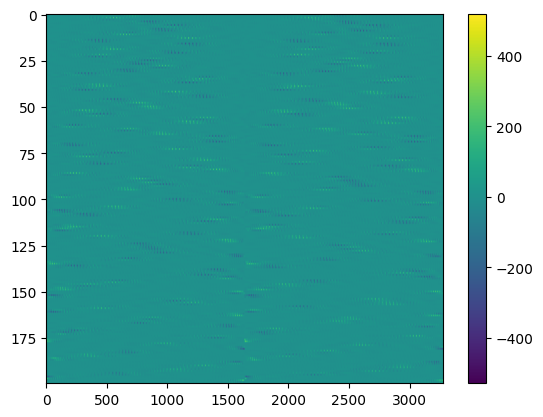

In [141]:
plt.imshow(response_matrix_selected,aspect='auto')
plt.colorbar()
plt.show()

In [142]:
print(reconstruction_matrix_selected.shape) # Jacobian going from modes to pixels

print(response_matrix_selected.T.shape) # Jacobian transforming from pixels to modes

(200, 3276)
(3276, 200)


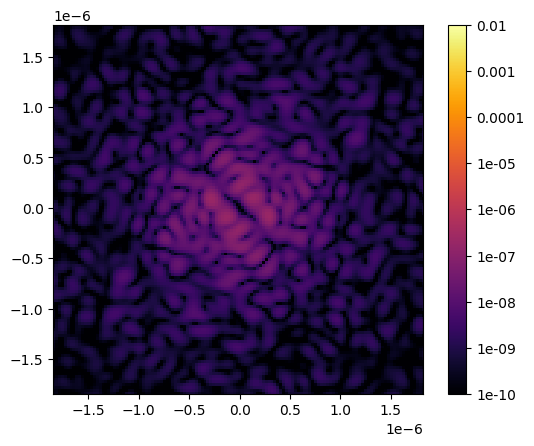

In [146]:
wfout = optical_system(sa(wf))
imshow_psf(wfout.power / norm, vmax=1e-2, vmin=1e-10)
plt.show()

In [194]:
TT = TipTiltMirror(pupil_grid)
TT.actuators[0] = 1.5/5 * sr / 2

imperfect_optical_system = OpticalSystem([coro, TT, prop,])
imperfect_pwp_sensor = make_pairwise_probing_sensor(probe_1=400, probe_2=401, probe_amp=0.01*wavelength, dm=deformable_mirror, optical_system=imperfect_optical_system)

In [195]:
# def run_iefc(get_image, dark_zone, num_modes, jacobian, rcond=1e-3):
#     # Calculate EFC matrix
#     iefc_matrix = inverse_tikhonov(jacobian, rcond)

#     # Run EFC loop
#     current_actuators = np.zeros(num_modes)

#     actuators = []
#     electric_fields = []
#     images = []

#     for i in range(50):
#         img = get_image(current_actuators)  # TODO: May need to adapt this for current code

#         electric_field = img.electric_field
#         image = img.intensity

#         actuators.append(current_actuators.copy())
#         electric_fields.append(electric_field)
#         images.append(image)

#         x = np.concatenate((electric_field[dark_zone].real, electric_field[dark_zone].imag))
#         y = iefc_matrix.dot(x)

#         current_actuators = current_actuators -iefc_loop_gain * y

#     return actuators, electric_fields, images

# actuators, electric_fields, images = run_iefc(get_image, dark_zone, len(influence_functions), jacobian)


### PID - controller
# Proportional - Integral - Differential controller
# e = (Y - U)
# U = p * e + k * integral e(t) dt + g * d/dt e(t)
# U = k * integral e(t)

# Integral controller <-> Integrator
# U_i+1 = U_i + gain * e(t_i)
# system is only stable for gains < gain_max

fourier_dm_selected.flatten()
zmodes = make_zernike_basis(3, Dtel, pupil_grid)
sa = SurfaceAberration(pupil_grid, 0.1 * wavelength, Dtel, exponent=-2.5, refractive_index=-1, aperture=telescope_pupil, remove_modes=zmodes)
num_iterations = 20

actuator_cmds = np.zeros(fourier_dm_selected.num_actuators)

efc_gain = 0.5

current_cmds = [] # This will serve as our dm_i? I am not exactly sure
image_cube = []

image_cube.append(imperfect_optical_system(fourier_dm_selected(sa(wf))).power / norm)
for i in range(num_iterations):

    wf_output = fourier_dm_selected(sa(wf))

    
    diff_images = imperfect_pwp_sensor(wf_output)  # Perform PWP

    pwp_measurement = extract_measurement_from_difference_images(diff_images, dark_hole_pixels>0) # Extract diff images
    
    # current_cmds = np.append(actuator_cmds.copy())

    ef_error = reconstruction_matrix_selected.dot(pwp_measurement) # Transform WF sensing measurement into DM pattern that gives us error
    actuator_cmds -= efc_gain*ef_error # Apply opposite phase to DM so as to cancel E-field

    fourier_dm_selected.actuators = actuator_cmds # Send the dm_i+1 command(?)

    image_cube.append(imperfect_optical_system(fourier_dm_selected(sa(wf))).power / norm)



    # E-field error = 
    


##### Pseudo code
    # For each iteration
        # Sense the WF
            # Do pairwise probing (turn above code into a function)--returns difference images
            # Mask difference images
        # Process the WF into a command
            # EF error = dot double diff imgs w/ inverted Jacobian
            # Use integrator -> dm_i+1 = dm_i - gain * EF error
        # Send the command
        # send the dm_i+1 command to the dm

image_cube = Field(image_cube, focal_grid)

/home/jasper/hcipy/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


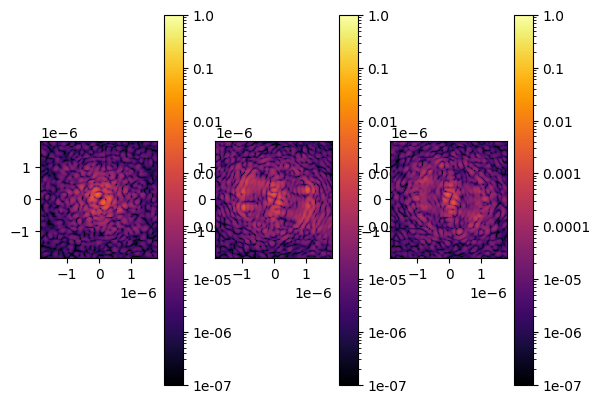

In [196]:
plt.subplot(1,3,1)
imshow_psf(image_cube[0], vmax=1, vmin=1e-7)
plt.subplot(1,3,2)
imshow_psf(image_cube[10], vmax=1, vmin=1e-7)
plt.subplot(1,3,3)
imshow_psf(image_cube[-1], vmax=1, vmin=1e-7)
plt.show()

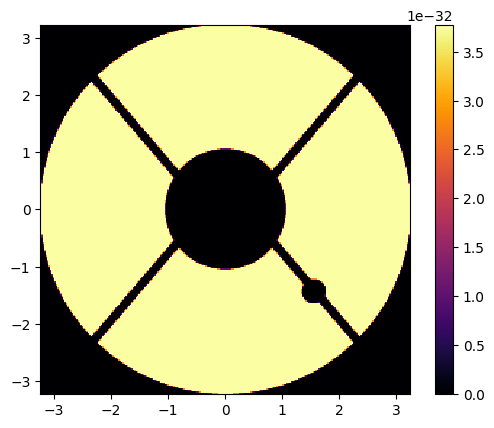

In [21]:
# Propagate light through Perfect CG from pupil plane to Lyot plane
wf = Wavefront(telescope_pupil, wavelength)
wf.total_power = 1 
lyot_plane = coro(wf)

imshow_field(lyot_plane.intensity, cmap='inferno')
plt.colorbar()
plt.show()


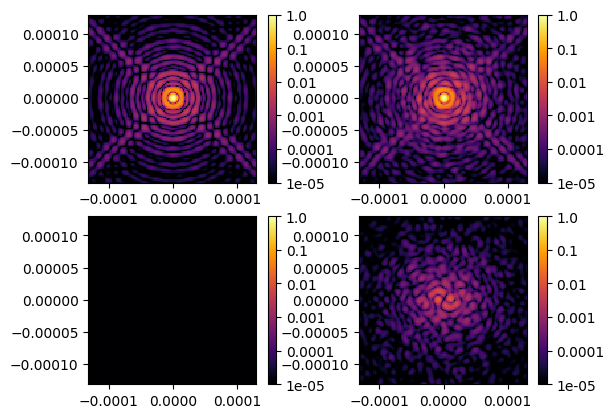

In [35]:
# deformable_mirror.random(0.2 * wavelength)


psf = prop(wf).power # prop = lense
aberrated_psf = prop(sa(wf)).power # prop = lense
norm = psf.max()

corim = prop(coro(wf)).power # prop = lense
aberrated_corim = prop(coro(sa(wf))).power # prop = lense

plt.subplot(2,2,1)
imshow_psf(psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,2)
imshow_psf(aberrated_psf / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,3)
imshow_psf(corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.subplot(2,2,4)
imshow_psf(aberrated_corim / norm, vmax=1, vmin=1e-5,) # Plot in log scale
plt.show()

/tmp/ipykernel_58937/3554996406.py:5: RuntimeWarning: divide by zero encountered in log10
  imshow_field(np.log10(img / focal_image.intensity.max()), vmin=-5, vmax=0, cmap='inferno')


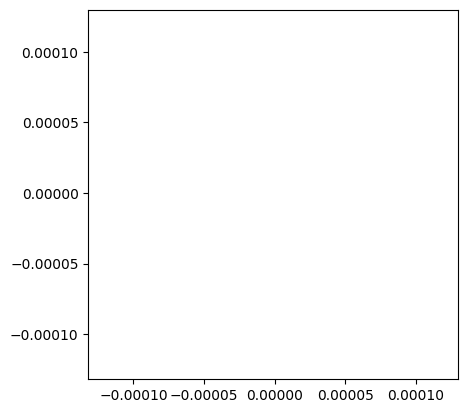

In [279]:
# Look at off-axis object to see star again
wf = Wavefront(telescope_pupil * np.exp(2j * np.pi * pupil_grid.x * 1.5))
img = prop(lyot_stop(coro(wf))).intensity

imshow_field(np.log10(img / focal_image.intensity.max()), vmin=-5, vmax=0, cmap='inferno')
plt.show()

In [36]:
# Fourier at 5 lambda/D
# cosine:  np.cos(2 * np.pi * 5 * pupil_grid.x / Dtel)

In [ ]:
# # Jacobian (iEFC)

# response_matrix = [] # Initialize empty vector of slopes

# probe_amp = 0.01 * wavelength # Set a probe amplitude
# calibration_amp = 0.01 * wavelength
# # probe_amp2 = 0.01 * wavelength # Set a probe amplitude


# wf = Wavefront(telescope_pupil, wavelength) # Reference WF
# wf.total_power = 1

# norm = prop(wf).power.max() # Normalize w/ unaberrated WF

# num_modes = deformable_mirror.num_actuators # TODO: Need to constrain number of modes to just the control region? 

# #Change num_modes for debugging 
# num_modes = 5

# amps = np.ones(num_modes) * probe_amp
# # amps2 = np.ones(num_modes) * probe_amp2

# deformable_mirror.flatten()

# for ind in range(num_modes):
#     if ind % 10 == 0:
#         print('Measure response to mode {:d} / {:d}'.format(ind + 1, num_modes))
    
#     calibration_images = []
#     for cal_amp in [-calibration_amp, calibration_amp]:

#         # Add the mode that we are calibrating
#         deformable_mirror.actuators[ind] += cal_amp

#         difference_images = []
#         for probe_pattern in [400, 401]:    # Select actuators 400 and 401 to probe
#             # Apply +/- probe 1
#             probed_psfs = []
#             for amp in [-probe_amp, probe_amp]:
#                 deformable_mirror.actuators[probe_pattern] += amp   # Apply a probe on DM

#                 # Propagate WF through system
#                 dm_wf = deformable_mirror.forward(wf) # WF after DM
#                 lyot_wf = coro(dm_wf) # WF in the Lyot Plane
#                 psf = prop(lyot_wf).power
#                 probed_psfs.append(psf)

#                 deformable_mirror.actuators[probe_pattern] -= amp
#                 # plt.figure()
#                 # imshow_psf(psf / norm, vmin=1e-8, vmax=1e-2)
#                 # Compute difference image 1
#             diff_image = probed_psfs[1] - probed_psfs[0]
#             # print(diff_image)
#             difference_images.append(diff_image)
    
#             pwp_measurement = np.concatenate((difference_images[0], difference_images[1]))
#         calibration_images.append(pwp_measurement)

#         # Remove the mode that we are calibrating
#         deformable_mirror.actuators[ind] -= calibration_amp


#     slope =  ((calibration_images[1] - calibration_images[0])/(2*calibration_amp)) # Construct slope vector

#     response_matrix.append(slope) # Append slope vector to response matrix

#     plt.subplot(1,2,1)
#     imshow_field(difference_images[0])

#     plt.subplot(1,2,2)
#     imshow_field(difference_images[1])
#     plt.show()

#     #deformable_mirror.actuators[ind-1] = amp*probe_amp # Apply +/- probe 2

#     # Propagate WF through system
#     #dm_wf = deformable_mirror.forward(wf) # WF after DM
#     #lyot_wf = coro(dm_wf) # WF in the Lyot Plane
#     #psf = prop(lyot_wf).power

#     # Compute difference image
#     #diff_image2 = psf[1] - psf[0]

#     #pwp_signal = [diff_image1, diff_image2] # Obtain pairwise probing signal

#     #slope =  probe_amp*((pwp_signal[0] - pwp_signal[1])/(2*amp)) # Construct slope vector

#     #response_matrix.append(slope) # Append slope vector to response matrix


# #################################### JACOBIAN PSEUDOCODE IEFC ##################################################

# # Initialize empty vector of slopes (response matrix)
# # For each mode
# #   For amplitude in [-amp, amp]
#     #   Apply mode on DM w/ a given amplitude

#     #   Apply + probe 1
#     #   Propagate WF through system
#     #   Take intensity image (PSF)
#     #   Apply - probe 1
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Compute difference image 1

#     #   Apply + probe 2
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Apply - probe 2
#     #   Propagate WF through system
#     #   Take intensity image
#     #   Compute difference image 2

#     #   Pair-wise probing sensing signal = [diff 1, diff_2]
#     #   Concatenate intensity differences
#     #   Construct slope vector -- amplitude * [(diff 1 - diff 2)/(2*amp)]
# #   Append slope vector to response matrix

    





In [ ]:

for fx in fxs:
    for fy in fys:
        np.cos(2 * np.pi * fx * pupil_grid.x / Dtel + 2 * np.pi * fy * pupil_grid.y / Dtel)